# Object Detection Testing


## Configuration
* Add your model labels and frozen graph files to a directory inside custom_models/
* Create a directory named after your model inside processed_images/
* Add your test images inside test_images/YOUR_MODEL_NAME
* Set the model name and the amount of classes

In [19]:
MODEL_NAME = 'example_model'
NUM_CLASSES = 90

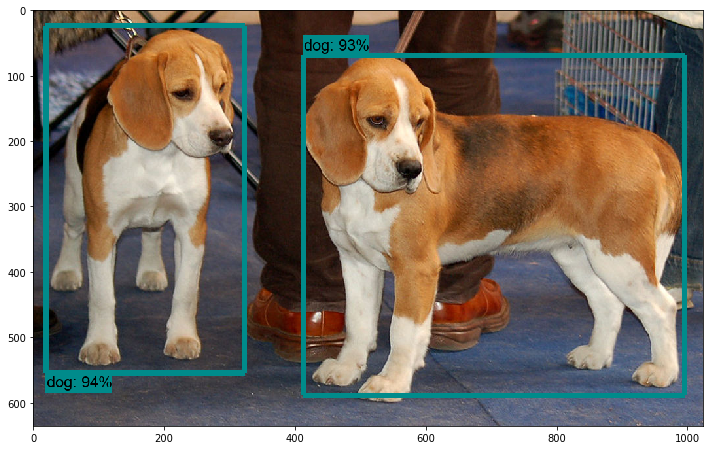

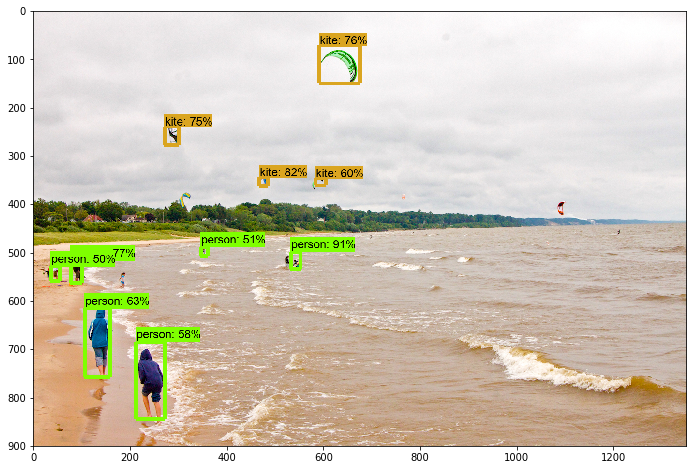

In [20]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from utils import label_map_util

from utils import visualization_utils as vis_util

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'custom_models/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'custom_models/' + MODEL_NAME + '/label_map.pbtxt'

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'test_images/' + MODEL_NAME

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

import cv2
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
       
       
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for (path, dirs, files) in os.walk(PATH_TO_TEST_IMAGES_DIR):
          for file in files:
            image_path = PATH_TO_TEST_IMAGES_DIR+ '/' + file
            image = Image.open(image_path)
            
            #the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            
            #Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            
            # Changing the color from BGR (wich is used by openCV to RGB)
            image_np_ok=cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            
            #Saving the image
            cv2.imwrite(os.path.abspath( 'processed_images/'+ MODEL_NAME + '/' + file) ,image_np_ok)